# Finger count detector

In this notebook, we use some advanced concepts like Image segmentation and Convex hull to recognise the number of fingers a person raises and display the count

In [1]:
import numpy as np
import cv2
from sklearn.metrics import pairwise

### Set up background and accumulated weight

In [2]:
# This background will be a global variable that we update through a few functions
background = None

# Start with a halfway point between 0 and 1 of accumulated weight
accumulated_weight = 0.5

# Manually set up our ROI for grabbing the hand.
# Feel free to change these. But make sure that during the first frame, the frame is "empty", i.e there are no objects there
roi_top = 20
roi_bottom = 300
roi_right = 300
roi_left = 600

### Strategy:
1. Grab an ROI
2. Calculate a running average background value for, say, 60 frames of video

In [3]:
def calc_accum_avg(frame, accumulated_weight):
    '''
    Given a frame and a previous accumulated weight, computed the weighted average of the image passed in.
    '''
    
    # Grab the background
    global background
    
    # For first time, create the background from a copy of the frame.
    if background is None:
        background = frame.copy().astype("float")
        return None

    # compute weighted average, accumulate it and update the background
    cv2.accumulateWeighted(frame, background, accumulated_weight)

### Once the hand enters the region, we detect change and apply thresholding to isolate hand segement

In [4]:
def segment(frame, threshold=25):
    global background
    
    # Calculates the Absolute Differentce between the backgroud and the passed in frame
    diff = cv2.absdiff(background.astype("uint8"), frame)

    # Apply a threshold to the image so we can grab the foreground
    # We only need the threshold, so we will throw away the first item in the tuple with an underscore _
    thresh, thresholded = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)

    # Grab the external contours form the image
    # Again, only grabbing what we need here and throwing away the rest
    contours, hierarchy = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # If length of contours list is 0, then we didn't grab any contours!
    if len(contours) == 0:
        return None
    else:
        # Given the way we are using the program, the largest external contour should be the hand (largest by area)
        # This will be our segment
        hand_segment = max(contours, key=cv2.contourArea)
        
        # Return both the hand segment and the thresholded hand image
        return (thresholded, hand_segment)

### Using Convex Hull to draw a polygon

Use convex hull to draw polygon around the hand, using angle between detected fingers, we detect finger count.
A convex hull draws a polygon by connecting points along the MOST EXTERNAL POINTS in a frame

### Steps:
1. The hull formed would look something like this: 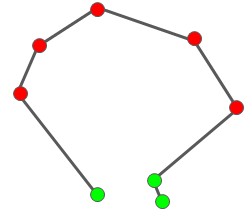
2. First, we will calculate 4 points: Extreme Left, right, top and bottom like so: 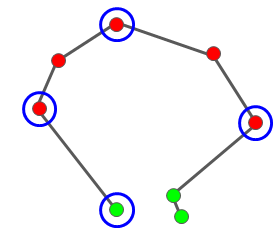
3. Then we calculate the intersection of Top-bottom and Left-right as the center of the hand: 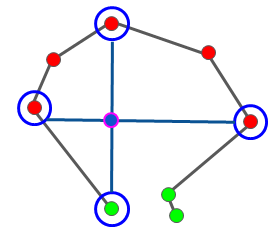
4. Let d = distance of furthest point from this center
5. Use a particlar ration of d to form a circle or radius r = d * ratio 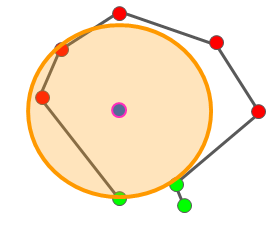
6. Idea: Any points outside this circle, and far from bottom (bottom is wrist, no fingers), should be fingers 

In [5]:
def count_fingers(thresholded, hand_segment):
    
    # Calculate the convex hull of the hand segment
    conv_hull = cv2.convexHull(hand_segment)
    
    # Now the convex hull will have at least 4 most outward points, on the top, bottom, left, and right.
    # Let's grab those points by using argmin and argmax. (Read documentation again)

    # Find the top, bottom, left, and right.
    # Then make sure they are in tuple format
    top    = tuple(conv_hull[conv_hull[:, :, 1].argmin()][0])
    bottom = tuple(conv_hull[conv_hull[:, :, 1].argmax()][0])
    left   = tuple(conv_hull[conv_hull[:, :, 0].argmin()][0])
    right  = tuple(conv_hull[conv_hull[:, :, 0].argmax()][0])

    # We may assume that the center of the hand is half way between the top and bottom and halfway between left and right
    cX = (left[0] + right[0]) // 2
    cY = (top[1] + bottom[1]) // 2

    # find the maximum euclidean distance between the center of the palm
    # and the most extreme points of the convex hull
    
    # Calculate the Euclidean Distance between the center of the hand and the left, right, top, and bottom.
    distance = pairwise.euclidean_distances([(cX, cY)], Y=[left, right, top, bottom])[0]
    
    # Grab the largest distance
    max_distance = distance.max()
    
    # Create a circle with 90% radius of the max euclidean distance
    radius = int(0.8 * max_distance)
    circumference = (2 * np.pi * radius)

    # Not grab an ROI of only that circle
    circular_roi = np.zeros(thresholded.shape[:2], dtype="uint8")
    
    # draw the circular ROI
    cv2.circle(circular_roi, (cX, cY), radius, 255, 10)
    
    
    # Using bit-wise AND with the cirle ROI as a mask.
    # This then returns the cut out obtained using the mask on the thresholded hand image.
    circular_roi = cv2.bitwise_and(thresholded, thresholded, mask=circular_roi)

    # Grab contours in circle ROI
    contours, hierarchy = cv2.findContours(circular_roi.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Finger count starts at 0
    count = 0

    # loop through the contours to see if we count any more fingers.
    for cnt in contours:
        
        # Bounding box of countour
        (x, y, w, h) = cv2.boundingRect(cnt)

        # Increment count of fingers based on two conditions:
        
        # 1. Contour region is not the very bottom of hand area (the wrist)
        out_of_wrist = ((cY + (cY * 0.25)) > (y + h))
        
        # 2. Number of points along the contour does not exceed 25% of the circumference of the circular ROI (otherwise we're counting points off the hand)
        limit_points = ((circumference * 0.25) > cnt.shape[0])
        
        if  out_of_wrist and limit_points:
            count += 1

    return count

## Application cell:

In [7]:
cam = cv2.VideoCapture(0)

# Intialize a frame count
num_frames = 0

# keep looping, until interrupted
while True:
    # get the current frame
    ret, frame = cam.read()

    # flip the frame so that it is not the mirror view
    frame = cv2.flip(frame, 1)

    # clone the frame
    frame_copy = frame.copy()

    # Grab the ROI from the frame
    roi = frame[roi_top:roi_bottom, roi_right:roi_left]

    # Apply grayscale and blur to ROI
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (7, 7), 0)

    # For the first 30 frames we will calculate the average of the background.
    # We will tell the user while this is happening
    if num_frames < 30:
        calc_accum_avg(gray, accumulated_weight)
        if num_frames <= 29:
            cv2.putText(frame_copy, "PLEASE WAIT! GETTING BACKGROUND AVG.", (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            cv2.imshow("Finger Count",frame_copy)
            
    else:
        # Now that we have the background, we can segment the hand.
        
        # Segment the hand region
        hand = segment(gray)

        # First check if we were able to actually detect a hand
        if hand is not None:
            # Unpack
            thresholded, hand_segment = hand

            # Draw contours around hand segment
            cv2.drawContours(frame_copy, [hand_segment + (roi_right, roi_top)], -1, (255, 0, 0),1)

            # Count the fingers
            fingers = count_fingers(thresholded, hand_segment)

            # Display count
            cv2.putText(frame_copy, str(fingers), (70, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

            # Also display the thresholded image
            cv2.imshow("Thesholded", thresholded)

    # Draw ROI Rectangle on frame copy
    cv2.rectangle(frame_copy, (roi_left, roi_top), (roi_right, roi_bottom), (0,0,255), 5)

    # increment the number of frames for tracking
    num_frames += 1

    # Display the frame with segmented hand
    cv2.imshow("Finger Count", frame_copy)

    # Close windows with Esc
    if cv2.waitKey(1) & 0xFF == 27:
        break

# Release the camera and destroy all the windows
cam.release()
cv2.destroyAllWindows()